# Training configuration

In [ ]:
# training configuration
noise_dim = 32
dim = 128
batch_size = 32

log_step = 100
epochs = 5000+1
learning_rate = 5e-4
models_dir = 'model'

In [ ]:
import pandas as pd

df = pd.read_csv('Copy of only_bots.csv')
print(df.columns)

Index(['Flow Duration', 'Total Fwd Packet', 'Total Bwd packets',
       'Total Length of Fwd Packet', 'Total Length of Bwd Packet',
       'Fwd Packet Length Max', 'Fwd Packet Length Min',
       'Fwd Packet Length Mean', 'Fwd Packet Length Std',
       'Bwd Packet Length Max', 'Bwd Packet Length Min',
       'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s',
       'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Max', 'Fwd IAT Min',
       'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max',
       'Bwd IAT Min', 'Fwd PSH Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Packet Length Min', 'Packet Length Max', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count',
       'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count',
       'Down/Up Ratio', 'Average Packet Size', 'Fwd Segment Size

Next, we will encode all [categorical features](https://en.wikipedia.org/wiki/Categorical_variable) to integer values. We are simply encoding the features to numerical values and are not using one hot encoding as its not required for GANs. 

### Transform the data

Next, we apply `PowerTransformer` on all the fields to get a Gaussian distribution for the data. 

In [ ]:
# import numpy as np

# df_healthcare_expenses = pd.cut(df['HEALTHCARE_EXPENSES'], bins=np.linspace(HEALTHCARE_EXPENSES_MIN, HEALTHCARE_EXPENSES_MAX, 21), labels=False)
# df_healthcare_coverage = pd.cut(df['HEALTHCARE_COVERAGE'], bins=np.linspace(HEALTHCARE_COVERAGE_MIN, HEALTHCARE_COVERAGE_MAX, 21), labels=False)

# df.drop(["HEALTHCARE_EXPENSES", "HEALTHCARE_COVERAGE"], axis=1, inplace=True)

# df = pd.concat([df, df_healthcare_expenses, df_healthcare_coverage], axis=1)

In [ ]:
# from sklearn.preprocessing import PowerTransformer

# df[df.columns] = PowerTransformer(method='yeo-johnson', standardize=True, copy=True).fit_transform(df[df.columns])

# print(df)

## Train the Model

Next, lets define the neural network for generating synthetic data. We will be using a [GAN](https://www.wikiwand.com/en/Generative_adversarial_network) network that comprises of an generator and discriminator that tries to beat each other and in the process learns the vector embedding for the data. 

The model was taken from a [Github repository](https://github.com/ydataai/gan-playground) where it is used to generate synthetic data on credit card fraud data. 

In [ ]:
import os
import numpy as np

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras import Model

from tensorflow.keras.optimizers import Adam

class GAN():
    
    def __init__(self, gan_args):
        [self.batch_size, lr, self.noise_dim,
         self.data_dim, layers_dim] = gan_args

        self.generator = Generator(self.batch_size).\
            build_model(input_shape=(self.noise_dim,), dim=layers_dim, data_dim=self.data_dim)

        self.discriminator = Discriminator(self.batch_size).\
            build_model(input_shape=(self.data_dim,), dim=layers_dim)

        optimizer = Adam(lr, 0.5)

        # Build and compile the discriminator
        self.discriminator.compile(loss='binary_crossentropy',
                                   optimizer=optimizer,
                                   metrics=['accuracy'])

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.noise_dim,))
        record = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(record)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def get_data_batch(self, train, batch_size, seed=0):
        # # random sampling - some samples will have excessively low or high sampling, but easy to implement
        # np.random.seed(seed)
        # x = train.loc[ np.random.choice(train.index, batch_size) ].values
        # iterate through shuffled indices, so every sample gets covered evenly

        start_i = (batch_size * seed) % len(train)
        stop_i = start_i + batch_size
        shuffle_seed = (batch_size * seed) // len(train)
        np.random.seed(shuffle_seed)
        train_ix = np.random.choice(list(train.index), replace=False, size=len(train))  # wasteful to shuffle every time
        train_ix = list(train_ix) + list(train_ix)  # duplicate to cover ranges past the end of the set
        x = train.loc[train_ix[start_i: stop_i]].values
        return np.reshape(x, (batch_size, -1))
        
    def train(self, data, train_arguments):
        [cache_prefix, epochs, sample_interval] = train_arguments
        
        data_cols = data.columns

        # Adversarial ground truths
        valid = np.ones((self.batch_size, 1))
        fake = np.zeros((self.batch_size, 1))

        for epoch in range(epochs):    
            # ---------------------
            #  Train Discriminator
            # ---------------------
            batch_data = self.get_data_batch(data, self.batch_size)
            noise = tf.random.normal((self.batch_size, self.noise_dim))

            # Generate a batch of new images
            gen_data = self.generator.predict(noise)
    
            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(batch_data, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_data, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    
            # ---------------------
            #  Train Generator
            # ---------------------
            noise = tf.random.normal((self.batch_size, self.noise_dim))
            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch(noise, valid)
    
            # Plot the progress
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100 * d_loss[1], g_loss))
    
            # If at save interval => save generated events
            if epoch % sample_interval == 0:
                #Test here data generation step
                # save model checkpoints
                model_checkpoint_base_name = 'model/' + cache_prefix + '_{}_model_weights_step_{}.h5'
                self.generator.save_weights(model_checkpoint_base_name.format('generator', epoch))
                self.discriminator.save_weights(model_checkpoint_base_name.format('discriminator', epoch))

                #Here is generating the data
                z = tf.random.normal((432, self.noise_dim))
                gen_data = self.generator(z)
                print('generated_data')

    def save(self, path, name):
        assert os.path.isdir(path) == True, \
            "Please provide a valid path. Path must be a directory."
        model_path = os.path.join(path, name)
        self.generator.save_weights(model_path)  # Load the generator
        return
    
    def load(self, path):
        assert os.path.isdir(path) == True, \
            "Please provide a valid path. Path must be a directory."
        self.generator = Generator(self.batch_size)
        self.generator = self.generator.load_weights(path)
        return self.generator
    
class Generator():
    def __init__(self, batch_size):
        self.batch_size=batch_size
        
    def build_model(self, input_shape, dim, data_dim):
        input= Input(shape=input_shape, batch_size=self.batch_size)
        x = Dense(dim, activation='relu')(input)
        x = Dense(dim * 2, activation='relu')(x)
        x = Dense(dim * 4, activation='relu')(x)
        x = Dense(data_dim)(x)
        return Model(inputs=input, outputs=x)

class Discriminator():
    def __init__(self,batch_size):
        self.batch_size=batch_size
    
    def build_model(self, input_shape, dim):
        input = Input(shape=input_shape, batch_size=self.batch_size)
        x = Dense(dim * 4, activation='relu')(input)
        x = Dropout(0.1)(x)
        x = Dense(dim * 2, activation='relu')(x)
        x = Dropout(0.1)(x)
        x = Dense(dim, activation='relu')(x)
        x = Dense(1, activation='sigmoid')(x)
        return Model(inputs=input, outputs=x)

Next, lets define the training parameters for the GAN network. We would be using a batch size of 32 and train it for 5000 epochs.

In [ ]:
data_cols = df.columns

In [ ]:
#Define the GAN and training parameters
noise_dim = 32
dim = 128
batch_size = 32

log_step = 100
epochs = 400+1
learning_rate = 5e-4
models_dir = 'model'

df[data_cols] = df[data_cols]

print(df.shape[1])

gan_args = [batch_size, learning_rate, noise_dim, df.shape[1], dim]
train_args = ['', epochs, log_step]

61


In [ ]:
!mkdir model

mkdir: cannot create directory ‘model’: File exists


Finally, let's run the training and see if the model is able to learn something. 

In [ ]:
model = GAN

#Training the GAN model chosen: Vanilla GAN, CGAN, DCGAN, etc.
synthesizer = model(gan_args)
synthesizer.train(df, train_args)

0 [D loss: 0.691756, acc.: 50.00%] [G loss: 0.682237]
generated_data
1 [D loss: 0.635549, acc.: 56.25%] [G loss: 0.717633]
2 [D loss: 0.590742, acc.: 62.50%] [G loss: 0.748142]
3 [D loss: 0.561187, acc.: 68.75%] [G loss: 0.764575]
4 [D loss: 0.567118, acc.: 51.56%] [G loss: 0.736825]
5 [D loss: 0.598048, acc.: 50.00%] [G loss: 0.655686]
6 [D loss: 0.737928, acc.: 50.00%] [G loss: 0.545509]
7 [D loss: 0.786921, acc.: 50.00%] [G loss: 0.585138]
8 [D loss: 0.755780, acc.: 50.00%] [G loss: 0.685718]
9 [D loss: 0.735009, acc.: 48.44%] [G loss: 0.881937]
10 [D loss: 0.699525, acc.: 50.00%] [G loss: 1.094002]
11 [D loss: 0.693633, acc.: 51.56%] [G loss: 1.256850]
12 [D loss: 0.688845, acc.: 48.44%] [G loss: 1.227688]
13 [D loss: 0.710786, acc.: 50.00%] [G loss: 1.146537]
14 [D loss: 0.709233, acc.: 50.00%] [G loss: 1.062185]
15 [D loss: 0.685886, acc.: 50.00%] [G loss: 1.054078]
16 [D loss: 0.662424, acc.: 50.00%] [G loss: 1.016181]
17 [D loss: 0.653797, acc.: 60.94%] [G loss: 0.942537]
18 [D

In [ ]:
!mkdir model/gan
!mkdir model/gan/saved

mkdir: cannot create directory ‘model/gan’: File exists
mkdir: cannot create directory ‘model/gan/saved’: File exists


In [ ]:
#You can easily save the trained generator and loaded it aftwerwards

synthesizer.save('model/gan/saved', 'generator_patients')

Let's take a look at the Generator and Discriminator models. 

In [ ]:
synthesizer.generator.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(32, 32)]                0         
_________________________________________________________________
dense (Dense)                (32, 128)                 4224      
_________________________________________________________________
dense_1 (Dense)              (32, 256)                 33024     
_________________________________________________________________
dense_2 (Dense)              (32, 512)                 131584    
_________________________________________________________________
dense_3 (Dense)              (32, 61)                  31293     
Total params: 200,125
Trainable params: 200,125
Non-trainable params: 0
_________________________________________________________________


In [ ]:
synthesizer.discriminator.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(32, 61)]                0         
_________________________________________________________________
dense_4 (Dense)              (32, 512)                 31744     
_________________________________________________________________
dropout (Dropout)            (32, 512)                 0         
_________________________________________________________________
dense_5 (Dense)              (32, 256)                 131328    
_________________________________________________________________
dropout_1 (Dropout)          (32, 256)                 0         
_________________________________________________________________
dense_6 (Dense)              (32, 128)                 32896     
_________________________________________________________________
dense_7 (Dense)              (32, 1)                  

## Evaluation

Now, that we have trained the model let's see if the generated data is similar to the actual data. 

We plot the generated data for some of the model steps and see how the plot for the generated data changes as the networks learns the embedding more accurately. 

In [ ]:
models = {'GAN': ['GAN', False, synthesizer.generator]}

No handles with labels found to put in legend.


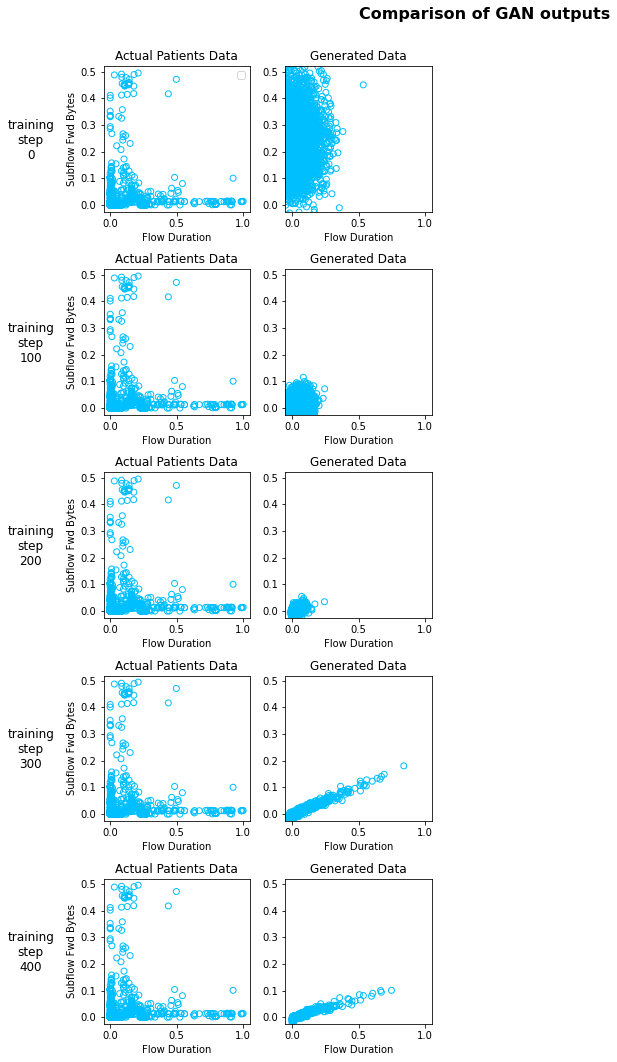

In [ ]:
import matplotlib.pyplot as plt

# Setup parameters visualization parameters
seed = 17
test_size = 5000 # number of fraud cases
noise_dim = 32

np.random.seed(seed)
z = np.random.normal(size=(test_size, noise_dim))
real = synthesizer.get_data_batch(train=df, batch_size=test_size, seed=seed)
real_samples = pd.DataFrame(real, columns=data_cols)

model_names = ['GAN']
colors = ['deepskyblue','blue']
markers = ['o','^']

col1, col2 = 'Flow Duration', 'Subflow Fwd Bytes'

base_dir = 'model/'

#Actual fraud data visualization
# model_steps = [ 0, 100, 200, 300, 400, 500, 1000, 2000, 3000, 4000, 5000]
model_steps = [ 0, 100, 200, 300, 400]
rows = len(model_steps)
columns = 5

axarr = [[]]*len(model_steps)

fig = plt.figure(figsize=(14,rows*3))

for model_step_ix, model_step in enumerate(model_steps):        
    axarr[model_step_ix] = plt.subplot(rows, columns, model_step_ix*columns + 1)
    
    for group, color, marker in zip(real_samples.groupby('Label'), colors, markers):
        plt.scatter( group[1][[col1]], group[1][[col2]], marker=marker, edgecolors=color, facecolors='none' )
    
    plt.title('Actual Patients Data')
    plt.ylabel(col2) # Only add y label to left plot
    plt.xlabel(col1)
    xlims, ylims = axarr[model_step_ix].get_xlim(), axarr[model_step_ix].get_ylim()
    
    if model_step_ix == 0: 
        legend = plt.legend()
        legend.get_frame().set_facecolor('white')
    
    i=0
    [model_name, with_class, generator_model] = models['GAN']

    generator_model.load_weights( base_dir + '_generator_model_weights_step_'+str(model_step)+'.h5')

    ax = plt.subplot(rows, columns, model_step_ix*columns + 1 + (i+1) )

    g_z = generator_model.predict(z)
    gen_samples = pd.DataFrame(g_z, columns=data_cols)
    plt.scatter( gen_samples[[col1]], gen_samples[[col2]], marker=markers[0], edgecolors=colors[0], facecolors='none' )
    plt.title("Generated Data")   
    plt.xlabel(data_cols[0])
    ax.set_xlim(xlims), ax.set_ylim(ylims)

plt.suptitle('Comparison of GAN outputs', size=16, fontweight='bold')
plt.tight_layout(rect=[0.075,0,1,0.95])

# Adding text labels for traning steps
vpositions = np.array([ i._position.bounds[1] for i in axarr ])
vpositions += ((vpositions[0] - vpositions[1]) * 0.35 )
for model_step_ix, model_step in enumerate( model_steps ):
    fig.text( 0.05, vpositions[model_step_ix], 'training\nstep\n'+str(model_step), ha='center', va='center', size=12)

plt.savefig('Comparison_of_GAN_outputs.png')

In [ ]:
print(gen_samples.shape)
gen_samples = gen_samples.loc[:, ~gen_samples.columns.str.contains('^Unnamed')]
# gen_samples.drop('Unnamed: 0', axis=1, inplace=True)
print(gen_samples.columns)
print(df.columns)
print(df.shape, gen_samples.shape)

(5000, 61)
Index(['Flow Duration', 'Total Fwd Packet', 'Total Bwd packets',
       'Total Length of Fwd Packet', 'Total Length of Bwd Packet',
       'Fwd Packet Length Max', 'Fwd Packet Length Min',
       'Fwd Packet Length Mean', 'Fwd Packet Length Std',
       'Bwd Packet Length Max', 'Bwd Packet Length Min',
       'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s',
       'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Max', 'Fwd IAT Min',
       'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max',
       'Bwd IAT Min', 'Fwd PSH Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Packet Length Min', 'Packet Length Max', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count',
       'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count',
       'Down/Up Ratio', 'Average Packet Size', 'Fwd S

In [ ]:
import math


x = gen_samples['Label']
x[x < 0] = 0
x[x > 1] = 1
x = np.round(x)
a = [math.floor(float(i)) for i in x]
gen_samples['Label'] = a
# gen_samples['Label']
print(gen_samples['Label'].value_counts())
gen_samples.to_csv('Generated_sample.csv')

1    5000
Name: Label, dtype: int64


Now let's try to do a feature by feature comparision between the generated data and the actual data. We will use python's `table_evaluator` library to compare the features. 

We call the `visual_evaluation` method to compare the actual date(`df`) and the generated data(`gen_df`).

In [ ]:
# from table_evaluator import load_data, TableEvaluator

# print(len(df), len(gen_samples))
# table_evaluator =  TableEvaluator(df, gen_samples)

# table_evaluator.visual_evaluation()

from table_evaluator import load_data, TableEvaluator

cat_cols = ['MARITAL', 'RACE', 'ETHNICITY', 'GENDER', 'BIRTHPLACE', 'CITY', 'STATE',
       'COUNTY', 'ZIP', 'HEALTHCARE_EXPENSES', 'HEALTHCARE_COVERAGE']

print(len(df), len(gen_samples))
table_evaluator =  TableEvaluator(df, gen_samples)

table_evaluator.visual_evaluation()

ModuleNotFoundError: ignored

 ## Conclusion

Some of the features in the syntehtic data match closely with actual data but there are some other features which were not learnt perfectly by the model. We can keep playing with the model and its hyperparameters to improve the model further. 

This post demonstrates that its fairly simply to use GANs to generate synthetic data where the actual data is sensitive in nature and can't be shared publicly. 